In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pickle
from random import randint, seed
import skimage.feature
import skimage.io
import sklearn.cluster
import sklearn.svm

%matplotlib inline
seed(42)

In [2]:
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [3]:
# Preprocessing of batches
def simplify_cifar():
    def nd2rgb(img):
        rgb = np.empty((32, 32, 3), dtype=np.uint8)
        N = 1024
        for i in range(3):
            rgb[:, :, i] = img[i*N : (i+1)*N].reshape(32, 32)
        return rgb
    
    
    def simplify_data(data):
        new_data = []
        for img in data:
            new_data.append(nd2rgb(img))
        return new_data


    def simplify_batch(batch, i=None):
        d = dict()
        d['data'] = simplify_data(batch[b'data'])
        d['labels'] = batch[b'labels']
        if i is None:
            file_name = 'test'
        else:
            file_name = 'train' + str(i)
        pickle.dump(d, open(PATH + file_name + '.pickle', 'wb'))


    PATH = './cifar-10-py/'
    for i in range(1, 6):
        batch = unpickle(PATH + 'data_batch_' + str(i))
        simplify_batch(batch, i)
    batch = unpickle(PATH + 'test_batch')
    simplify_batch(batch)


# simplify_cifar()

In [4]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def read_cifar(n):
    assert(1 <= n <= 5)
   
    path = './cifar-10/'
    train_batch = {'data': [], 'labels': []}
    for i in range(1, n+1):
        batch = unpickle(path + 'train' + str(i) + '.pickle')
        for img, label in zip(batch['data'], batch['labels']):
            train_batch['data'].append(img)
            train_batch['labels'].append(label)
    test_batch = unpickle(path + 'test.pickle')
    return train_batch, test_batch

In [5]:
train_batch, test_batch = read_cifar(1)

In [6]:
# ix = {label: 0 for label in label_names}

# def save_batch_by_class(batch):
#     for img, i in zip(batch['data'], batch['labels']):
#         label = label_names[i]
#         path = './cifar-10/' + label + '/' + str(ix[label]) + '.jpg'
#         skimage.io.imsave(path, img)
#         ix[label] += 1
        
# import os
# for label in label_names:
#     os.mkdir('./cifar-10/' + label)   

# save_batch_by_class(train_batch)
# save_batch_by_class(test_batch)

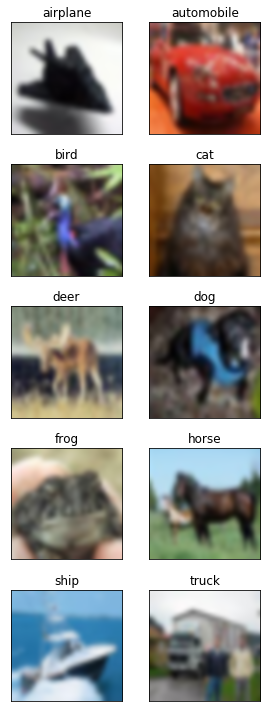

In [7]:
def plot_sample(img):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(img, interpolation='bicubic')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


def show_examples(batch):
    def get_examples():
        d = dict()
        data = batch['data']
        labels = batch['labels']
        for img, label in zip(data, labels):
            if len(d) == 10:
                break
            d[label] = img
        return d
    
    examples = get_examples()
    fig, ax = plt.subplots(5, 2, figsize=(4, 10), subplot_kw={'xticks': [], 'yticks': []})
    for i in range(10):
        ix = i // 2
        jx = i % 2
        ax[ix, jx].imshow(examples[i], interpolation='bicubic')
        ax[ix, jx].set_title(label_names[i])
    plt.tight_layout()


show_examples(train_batch)

In [8]:
def get_descriptors2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptor_algo = cv2.xfeatures2d.SURF_create()
    _, des = descriptor_algo.detectAndCompute(gray, None)
    return des


def get_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(gray, None)
    return des


def get_all_descriptors(batch):
    img2desc = {}
    all_descriptors = []
    n_img = len(batch['data'])
    for i, img in enumerate(batch['data']):
        if (i + 1) % 1000 == 0:
            print('{:.0f}%'.format(i / n_img * 100))
        des = get_descriptors(img)
        if des is None:
            continue
        img2desc[i] = des
        if des.shape[0] >= 5:
            for descriptor in des:
                all_descriptors.append(descriptor)
    print('{0} out of {1} images have at least 5 descriptors'.format(len(img2desc), n_img))
    return img2desc, all_descriptors

In [9]:
%%time

img2desc, all_descriptors = get_all_descriptors(train_batch)
print('Total number of descriptors:', len(all_descriptors))

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
9975 out of 10000 images have at least 5 descriptors
Total number of descriptors: 128421
Wall time: 13.3 s


In [21]:
def run_k_means(data, k):
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k, n_init=20, init_size=3*k).fit(data)
    s = 'Clustering in {0} clusters took {1} iterations'
    s = s.format(k, kmeans.n_iter_, kmeans.inertia_)
    print(s)
    return kmeans


def get_histogram(descriptors, kmeans):
    k = kmeans.n_clusters
    hist = np.zeros(k)
    words = kmeans.predict(descriptors)
    for word in words:
        hist[word] += 1
    return hist

In [22]:
# %%time

# K = list(range(2, 51))
# I = []
# for k in K:
#     kmeans = run_k_means(all_descriptors, k)
#     I.append(kmeans.inertia_)

# plt.plot(K, I, 'o-')
# k_ticks = list(range(2, len(K), 5))
# plt.xticks(k_ticks)

In [23]:
%%time
print("I'm here")

n_clusters = 500
all_descriptors = np.array(all_descriptors)
kmeans = run_k_means(all_descriptors, n_clusters)

I'm here
Clustering in 500 clusters took 11 iterations
Wall time: 14.1 s


In [13]:
%%time
print("I'm here")

n = len(img2desc)
y_train = np.zeros(n)
X_train = np.zeros((n, n_clusters))

i = 0
for img_ix, descriptors in img2desc.items():
    X_train[i,:] = get_histogram(descriptors, kmeans)
    y_train[i] = train_batch['labels'][img_ix]
    i += 1

print("Done")

I'm here
Done
Wall time: 9.28 s


In [14]:
%%time
print("I'm here")

svm = sklearn.svm.SVC(gamma='scale')
svm.fit(X_train, y_train)

print("DONE")

I'm here
DONE
Wall time: 1min 45s


In [15]:
cnt_bad = 0


def get_prediction(img, kmeans, svm):
    descriptors = get_descriptors(img)
    if descriptors is None:
        global cnt_bad
        cnt_bad += 1
        return randint(0, 9)
    hist = get_histogram(descriptors, kmeans)
    return svm.predict(hist.reshape(1, -1))


def get_all_predictions(batch, kmeans, svm):
    n_test = len(batch['data'])
    cnt_ok = 0
    for img, true_label in zip(batch['data'], batch['labels']):
        pred_label = get_prediction(img, kmeans, svm)
        if pred_label == true_label:
            cnt_ok += 1
    print('No descriptors were detected for {} images'.format(cnt_bad))
    print('Accuracy: {:.2f}'.format(cnt_ok / n_test))
    with open('accuracy.txt', 'w') as f:
        f.write('Accuracy: {:.2f}'.format(cnt_ok / n_test))

In [16]:
%%time
print("I'm here")

get_all_predictions(test_batch, kmeans, svm)
seed(42)

I'm here
No descriptors were detected for 24 images
Accuracy: 0.27
Wall time: 2min 4s


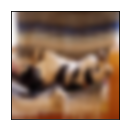

I guess this is
CAT
Its real label is
CAT


In [20]:
def classify_random(kmeans, svm):
    i = randint(0, 10000)
    img = test_batch['data'][i]
    plot_sample(img)
    label_pred = int(get_prediction(img, kmeans, svm))
    print('I guess this is')
    print(label_names[label_pred].upper())
    print('Its real label is')
    label_true = test_batch['labels'][i]
    print(label_names[label_true].upper())


classify_random(kmeans, svm)